# Bio_ClinicalBERTClassifier
#### Bio_ClinicalBERT for Kinetic Accident Classification
# Dataset 1: MIMIC-III TEXT DATA
#### NOTEEVENTS.csv.gz (https://physionet.org/content/mimiciii/1.4/NOTEEVENTS.csv.gz)

#### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import numpy as np
import os

## 1. Data exploration

In [7]:
data = pd.read_csv("NOTEEVENTS.csv.gz", low_memory = False)

In [8]:
print(data.info(),"\n")
print("Data head:", "\n" ,data.head(2), "\n")
print("ROW_ID is unique:", data["ROW_ID"].is_unique)
print("TEXT is unique:", data["TEXT"].is_unique)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB
None 

Data head: 
    ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE CHARTTIME STORETIME  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   

            CATEGORY DESCRIPTION  CGID  ISERROR  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   

                                                TEXT  
0  Admission Date:  [**2151-7-16**]       Dischar...  

In [9]:
data = data[["ROW_ID" , "TEXT"]]
data = data.drop_duplicates(subset="TEXT", keep="first")
print("Number of rows:" , data.shape[0])
print("TEXT is unique:", data["TEXT"].is_unique)

Number of rows: 2023185
TEXT is unique: True


In [10]:
# Calculate the number of words in the TEXT column
data['W_COUNT'] = data['TEXT'].apply(lambda x: len(str(x).split()))

Maximum number of words: 7980
Minimum number of words: 0
Average number of words: 248.73 



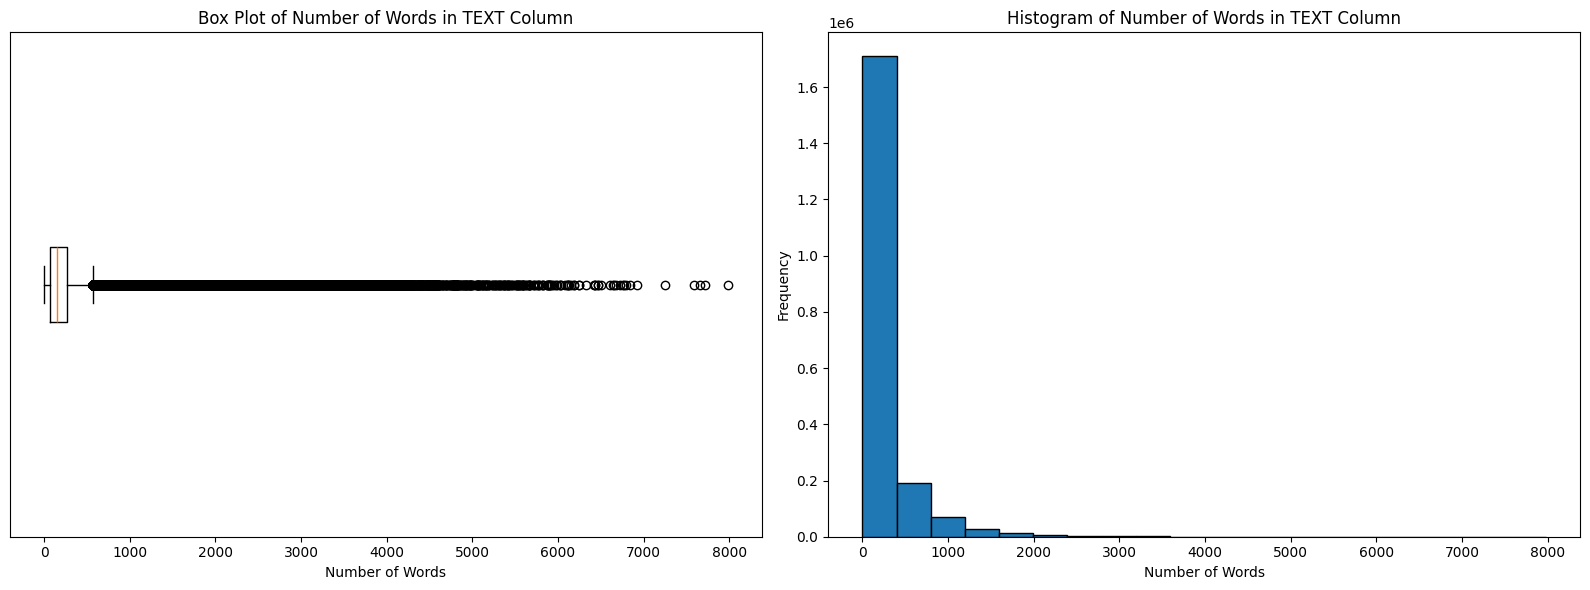

In [11]:
# Calculate statistics
max_words = data['W_COUNT'].max()
min_words = data['W_COUNT'].min()
avg_words = data['W_COUNT'].mean()

# Print statistics
print(f"Maximum number of words: {max_words}")
print(f"Minimum number of words: {min_words}")
print(f"Average number of words: {avg_words:.2f}", "\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Plotting parameters

# Box plot
ax[0].boxplot(data['W_COUNT'], vert=False)
ax[0].set_title('Box Plot of Number of Words in TEXT Column')
ax[0].set_xlabel('Number of Words')
ax[0].set_yticks([])

# Histogram
ax[1].hist(data['W_COUNT'], bins=20, edgecolor='black')
ax[1].set_title('Histogram of Number of Words in TEXT Column')
ax[1].set_xlabel('Number of Words')
ax[1].set_ylabel('Frequency')

# Plot
plt.tight_layout()
plt.show()

In [12]:
data = data[data["W_COUNT"] > 1]
print("Number of observations having word count less than or equal 512:",data[data["W_COUNT"] <= 512].shape[0])
print("Number of observations having word count more than 512:", data[data["W_COUNT"] > 512].shape[0])

Number of observations having word count less than or equal 512: 1794767
Number of observations having word count more than 512: 228312


In [13]:
# --- Heading counter function ---
def count_headings(dataframe, column_name='TEXT'):
    heading_counter = Counter()

    # Regular expression pattern to identify headings that end with a colon
    pattern = re.compile(r'\b[A-Za-z ]+?:')

    # Iterate through each row in the dataframe
    for text in dataframe[column_name].dropna():  # Dropping NaN values to ensure all entries are strings
        if isinstance(text, str):  # Ensure that the text is a string
            # Extract all headings using the regex pattern
            found_headings = pattern.findall(text)
            # Normalize and count each heading
            for heading in found_headings:
                normalized_heading = heading.strip()
                heading_counter[normalized_heading] += 1

    return heading_counter

In [14]:
headings = count_headings(data, column_name='TEXT')

In [17]:
# Print only headings appearing more than 12000 times, sorted by count in descending order
sorted_headings = sorted(headings.items(), key=lambda item: item[1], reverse=True)
for heading, count in sorted_headings:
    if count > 12000:
        print(f"{heading} {count}")

Reason: 629952
Plan: 527309
MEDICAL CONDITION: 499198
REASON FOR THIS EXAMINATION: 498823
Assessment: 457012
Response: 450494
Action: 448915
IMPRESSION: 443401
Admitting Diagnosis: 386765
Comments: 307366
P: 288818
INDICATION: 245672
FINDINGS: 241460
A: 213649
COMPARISON: 185148
mg Tablet Sig: 182426
CV: 179921
Allergies: 177061
Nutrition: 159282
Drains: 155895
HISTORY: 154075
Contrast: 151764
O: 151252
Communication: 144296
BP: 142137
Prophylaxis: 140187
Chief Complaint: 139758
HR: 139240
GU: 139207
GI: 138461
RR: 137813
Heart rhythm: 137692
Code status: 135381
Balance: 133701
Other labs: 132363
Height: 131211
Urine: 131082
Stool: 130475
PO: 130425
Total out: 130416
Total In: 130408
NG: 130244
Blood products: 130185
Other ICU medications: 129564
Last dose of Antibiotics: 129465
Infusions: 128993
TECHNIQUE: 128268
Tmax: 128151
ABG: 127869
Other medications: 126843
DVT: 126766
Stress ulcer: 125564
Lines: 125198
Glycemic Control: 124325
Skin: 123569
Neurologic: 122479
Delivery Device: 12

## 2. Data preprocessing

In [16]:
pdata = data.copy() # -To avoid warnings

### 2.1 Text extraction

In [19]:
# --- Define target heading variations ---
heading_variations = {
    # 'Admit Diagnosis': [
    #     'Admit diagnosis',
    #     'Admitting Diagnosis',
    #     'ADMIT DIAGNOSIS'
    # ],
    # 'Medical Condition': [
    #     'MEDICAL CONDITION',
    #     'Medical Condition'
    # ],
    'History of Present Illness': [
        'History of Present Illness',
    #     'HISTORY OF PRESENT ILLNESS',
    #     'HISTORY OF THE PRESENT ILLNESS',
    #     'History of the present illness',
    #     'HPI'
    ],
    # 'Chief Complaint': [
    #     'Chief Complaint',
    #     'chief complaint',
    #     'CHIEF COMPLAINT'
    # ]
}

# Create a mapping from lowercase variants to standardized headings.
variation_to_standard = {}
for standard, variations in heading_variations.items():
    for variant in variations:
        variation_to_standard[variant.lower()] = standard

# --- Build the regex pattern using only the target headings ---
# Escape each variant and sort by length (longer ones first to avoid partial matches)
escaped_headings = sorted(
    [re.escape(variant) for variant in variation_to_standard.keys()],
    key=len,
    reverse=True
)
headings_pattern = '|'.join(escaped_headings)

# The regex stops capturing when it sees a newline followed by a line that starts with some text and a colon.
pattern = re.compile(
    rf'(?P<heading>{headings_pattern})\s*:\s*'
    rf'(?P<content>.*?)(?=\n\s*[^:\n]+:\s*|\Z)',
    re.IGNORECASE | re.DOTALL
)

In [20]:
# --- Extraction Function ---
def extract_headings(text, pattern, variation_mapping):
    """
    For each target heading in text, capture its content.
    For headings known to be one-line (such as Admitting Diagnosis), only the first line is kept.
    Also, if the captured content is empty or its first nonempty line looks like another heading,
    the value is set to None.
    """
    matches = pattern.finditer(text)
    extracted = {}
    for match in matches:
        heading_variant = match.group('heading').strip().lower()
        content = match.group('content')  # may be multiline
        content_stripped = content.strip() if content else ''

        # Check if the first nonempty line itself looks like a heading (e.g., "24 Hour Events:")
        first_non_empty_line = None
        for line in content.splitlines():
            if line.strip():
                first_non_empty_line = line.strip()
                break
        if first_non_empty_line and re.match(r'^[^:]+:\s*$', first_non_empty_line):
            content_stripped = ''
        if not content_stripped:
            content_stripped = None

        standard_heading = variation_mapping.get(heading_variant)
        if standard_heading:
            # Special rule: for headings expected to be one line (e.g., Admitting Diagnosis),
            # take only the first line.
            if standard_heading == "Admit Diagnosis":
                first_line = content.splitlines()[0].strip() if content else ""
                content_stripped = first_line if first_line else None

            # Merge content if the heading appears more than once.
            if standard_heading in extracted:
                if extracted[standard_heading] is None:
                    extracted[standard_heading] = content_stripped
                else:
                    if content_stripped is not None:
                        extracted[standard_heading] += " " + content_stripped
            else:
                extracted[standard_heading] = content_stripped
    return extracted

In [21]:
extract = pdata['TEXT'].apply(lambda x: extract_headings(x, pattern, variation_to_standard))
extract = pd.json_normalize(extract)
pdata = pdata.join(extract)
print(pdata.head(3))

   ROW_ID                                               TEXT  W_COUNT  \
0     174  Admission Date:  [**2151-7-16**]       Dischar...      110   
1     175  Admission Date:  [**2118-6-2**]       Discharg...     1943   
2     176  Admission Date:  [**2119-5-4**]              D...     1426   

                          History of Present Illness  
0                                                NaN  
1  This is an 81-year-old female\nwith a history ...  
2  This 81 year old woman has a history of COPD. ...  


In [ ]:
# # Combine the columns for the clinical note
# clinical_columns = [
#     "Chief Complaint",
#     "Admit Diagnosis",
#     "Medical Condition",
#     "History of Present Illness"
# ]

# # Define a function that combines text from the row and returns np.nan if the combined string is empty.
# def combine_clinical_note(row):
#     note = ' '.join(
#         (x.strip() + ('.' if x.strip() and not x.strip().endswith('.') else ''))
#         for x in row if x.strip()
#     ).strip()
#     return note if note else np.nan

# # Fill missing values with empty strings and apply the function.
# pdata['CLINICAL_NOTE'] = pdata[clinical_columns].fillna('').apply(combine_clinical_note, axis=1)

In [24]:
# Create the new df - clinicalnotes(cnotes) with the text columns
cnotes = pdata[['ROW_ID', 'TEXT', 'History of Present Illness']]
print(cnotes.head(3), "\n")
print("History of Present Illness is unique:", cnotes['History of Present Illness'].is_unique)
print("History of Present Illness ROW_ID is unique:", cnotes['History of Present Illness'].is_unique)

   ROW_ID                                               TEXT  \
0     174  Admission Date:  [**2151-7-16**]       Dischar...   
1     175  Admission Date:  [**2118-6-2**]       Discharg...   
2     176  Admission Date:  [**2119-5-4**]              D...   

                          History of Present Illness  
0                                                NaN  
1  This is an 81-year-old female\nwith a history ...  
2  This 81 year old woman has a history of COPD. ...   

History of Present Illness is unique: False
History of Present Illness ROW_ID is unique: False


In [25]:
# Remove duplicates and null observations
cnotes = cnotes.drop_duplicates(subset="History of Present Illness", keep="first")
cnotes = cnotes.dropna(subset=['History of Present Illness'])
print("History of Present Illness ROW_ID is unique:", cnotes['ROW_ID'].is_unique)
print("History of Present Illness is unique:", cnotes['History of Present Illness'].is_unique)
print("Number of History of Present Illness observations:", cnotes.shape[0])

History of Present Illness ROW_ID is unique: True
History of Present Illness is unique: True
Number of History of Present Illness observations: 50694


### 2.2 Data cleaning

In [26]:
# --- Cleaner Function ---
class TextCleaner:
    def __init__(self):
        # Regex to match patterns like [** ... **], (** ... **), or ** ... **
        # Use a lazy quantifier (.*?) and DOTALL so we match across newlines or unusual characters.
        self.pattern = re.compile(
            r'\[\*\*.*?\*\*\]|\(\*\*.*?\*\*\)|\*\*.*?\*\*',
            flags=re.DOTALL
        )

    def remove_encodings(self, text):
        """Remove specific encoded patterns from the text."""
        return re.sub(self.pattern, '', text).strip()

    def clean_text(self, text):
        """General purpose text cleaning function, removing various patterns."""
        # 1. Remove the encoded patterns first
        text = self.remove_encodings(text)

        # 2. Remove any leftover sequences of asterisks (e.g., '****')
        text = re.sub(r'\*+', ' ', text)

        # 3. Replace multiple underscores with a single space
        text = re.sub(r'__+', ' ', text)

        # 4. Normalize whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # 5. Remove dates of the form YYYY-MM-DD
        text = re.sub(r'\d{4}-\d{1,2}-\d{1,2}', '', text)

        # 6. Remove brackets
        text = re.sub(r'[\(\)\[\]{}]', '', text)

        # 7. Remove punctuation (semicolon, colon, comma, dot, and question mark)
        # text = re.sub(r'[;,\.\?]', '', text)

        return text

    def apply_cleaning(self, dataframe, column_name='TEXT'):
        """Apply cleaning function to a DataFrame column."""
        CLEAN_TEXT = dataframe[column_name].apply(self.clean_text)
        dataframe = dataframe.assign(CLEAN_TEXT=CLEAN_TEXT)
        return dataframe

In [28]:
cleaner = TextCleaner()
cnotes = cleaner.apply_cleaning(dataframe = cnotes, column_name = "History of Present Illness")
print("CLEAN_TEXT is unique:", cnotes['CLEAN_TEXT'].is_unique)

CLEAN_TEXT is unique: False


In [29]:
cnotes = cnotes.drop_duplicates(subset="CLEAN_TEXT", keep="first")
print("CLEAN_TEXT is unique:", cnotes['CLEAN_TEXT'].is_unique)

CLEAN_TEXT is unique: True


In [30]:
text = cnotes.copy().drop(columns = {"TEXT", "History of Present Illness"})
text = text.rename(columns = {"CLEAN_TEXT": "TEXT"})

In [31]:
# Count the number of words
text['W_COUNT'] = text['TEXT'].apply(lambda x: len(str(x).split()))

In [32]:
# --- Duplicate sentence remover function ---
def remove_duplicate_sentences(text):
    # Use regex to split text into sentences; this handles common punctuation.
    sentences = re.split(r'(?<=[.!?]) +', text)
    seen = set()
    unique_sentences = []
    for sentence in sentences:
        if sentence not in seen:
            seen.add(sentence)
            unique_sentences.append(sentence)
    return " ".join(unique_sentences)


text["TEXT"] = text["TEXT"].apply(remove_duplicate_sentences)
print("Number of observations having word count more than 512:", text[text["W_COUNT"] > 512].shape[0])

Number of observations having word count more than 512: 350


In [33]:
# --- Truncate function ---
def truncate_text_to_512(text):
    # Ensure that text is a string
    if not isinstance(text, str):
        return text
    words = text.split()
    truncated = " ".join(words[:512])
    return truncated

# Truncate input to 512 words for Bio_ClinicalBERT to match its maximum input length.
text["TEXT"] = text["TEXT"].apply(truncate_text_to_512)

# Update word count
text['W_COUNT'] = text['TEXT'].apply(lambda x: len(str(x).split()))

Maximum number of words: 512
Minimum number of words: 0
Average number of words: 150.52 



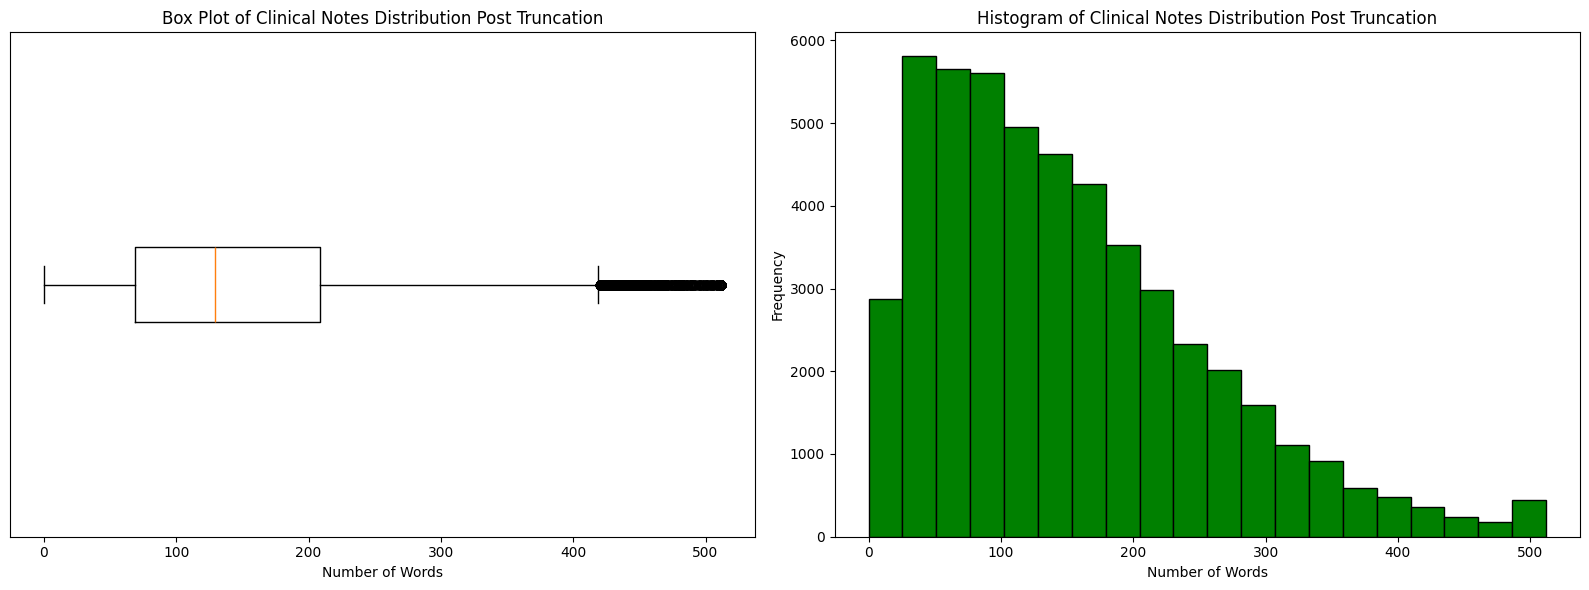

In [34]:
# Calculate statistics
max_words = text['W_COUNT'].max()
min_words = text['W_COUNT'].min()
avg_words = text['W_COUNT'].mean()

# Print statistics
print(f"Maximum number of words: {max_words}")
print(f"Minimum number of words: {min_words}")
print(f"Average number of words: {avg_words:.2f}", "\n")

# Set the figure and plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Box plot on the first subplot
ax[0].boxplot(text['W_COUNT'], vert=False)
ax[0].set_title('Box Plot of Clinical Notes Distribution Post Truncation')
ax[0].set_xlabel('Number of Words')
ax[0].set_yticks([])  # Hide y-axis ticks

# Histogram on the second subplot
ax[1].hist(text['W_COUNT'], bins=20, edgecolor='black', color='green')
ax[1].set_title('Histogram of Clinical Notes Distribution Post Truncation')
ax[1].set_xlabel('Number of Words')
ax[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap and plot
plt.tight_layout()
plt.show()

In [ ]:
# text.to_csv("clinical_text.csv", index = False)

## 3. Label Annotation using Dr. Jim Basilakis's (Domain Expert) Kinetic Trauma Regular-Expression

In [ ]:
# text = pd.read_csv("clinical_text.csv")

In [35]:
# --- Dr. Jim's (Domain Expert) vehicle regex ---
KTInj_regex = (
    r'\b(?:mva|mba|vehicle|bus|pedestrian|atv|passenger|ute|ped|bike|dirtbike|motorbike|pushbike|scooter|truck|'
    r'bicycle|motorcycle|driver|driving|rtc|rta|\d*km[a-zA-Z/]*|skateboard|surfing|surf|horse|collision|'
    r'crossing|buggy|ebike|jetski|vs car|car vs|car accident|moving car|traffic light|traffic lights|'
    r'hit by car|hit by a car|car hit|airbag|tyre|airbags|T boned)\b'
)

# Compile the regex with case-insensitive flag.
pattern = re.compile(KTInj_regex, re.IGNORECASE)

In [36]:
# --- Prediction function using the regex ---
def predict_ka(text):
    """
    Given a text string, return a tuple (label, responsible_keywords) where:
      - label is True if any vehicle-related keyword is found, else False.
      - responsible_keywords is a comma-separated string of the matched keywords in lower case (or None if no match).
    """
    # Find all matching keywords in the text.
    matches = pattern.findall(text)
    if matches:
        # Convert each match to lower case and remove duplicates by converting to a set.
        unique_matches = list(set(match.lower() for match in matches))
        # Sort the keywords.
        unique_matches.sort()
        return True, ", ".join(unique_matches)
    else:
        return False, None

In [37]:
# Predict the labels
text[['REGEX_LABEL', 'KEY']] = text['TEXT'].apply(lambda x: pd.Series(predict_ka(x)))

In [38]:
# Subset the true cases
true = text[text["REGEX_LABEL"] == True]
true = true.sort_values(by='KEY')
print(true.head(3),"\n")
print("Total no of rows:", true.shape[0])

       ROW_ID                                               TEXT  W_COUNT  \
28232   25650  Patient is 17 year old male brought in by afte...       41   
33303   27066  54 yo M, Pt has long h/o EtOH cirrhossis s/p T...       90   
34653   30114  22YO s/p unrestrained MVC. According to pt's f...       39   

       REGEX_LABEL     KEY  
28232         True  airbag  
33303         True  airbag  
34653         True  airbag   

Total no of rows: 2034


In [41]:
# true.to_csv("true.csv", index = False)

In [39]:
# Subset the false cases
false = text[text["REGEX_LABEL"] == False]
print(false.head(3),"\n")
print("Total no of rows:", false.shape[0])

   ROW_ID                                               TEXT  W_COUNT  \
1     175  This is an 81-year-old female with a history o...      115   
2     176  This 81 year old woman has a history of COPD. ...      244   
3     177  87 yo F with h/o CHF, COPD on 5 L oxygen at ba...      265   

   REGEX_LABEL   KEY  
1        False  None  
2        False  None  
3        False  None   

Total no of rows: 48525


In [42]:
# false.to_csv("false.csv", index = False)

## 4. Create the training set
#### The cases identified by regex were manually annotated, and domain-specific keywords were evaluated by human reviewers. This process helped identify edge cases and misclassifications, which were used to test the model’s performance.

In [68]:
train = pd.read_csv("s_train.csv")
train["W_COUNT"] = train["TEXT"].apply(lambda x: len(str(x).split()))

In [69]:
print(train.head(2), "\n")
print("Distribution of human annotated labels:","\n",train["LABEL"].value_counts())

   HADM_ID                                               TEXT  LABEL  W_COUNT
0   195344  47 year old male who complains of CARDIAC ARRE...    0.0      108
1   176418  This 65 year old gentleman has a history of a ...    0.0      105 

Distribution of human annotated labels: 
 LABEL
1.0    1309
0.0    1132
Name: count, dtype: int64


##### A total of 725 edge cases, including misclassifications, were identified through human annotation.

True cases:  max=623,  min=8,  avg=60.72
False cases: max=542,  min=4,  avg=129.26



<ipython-input-71-6ea454aede34>:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot(


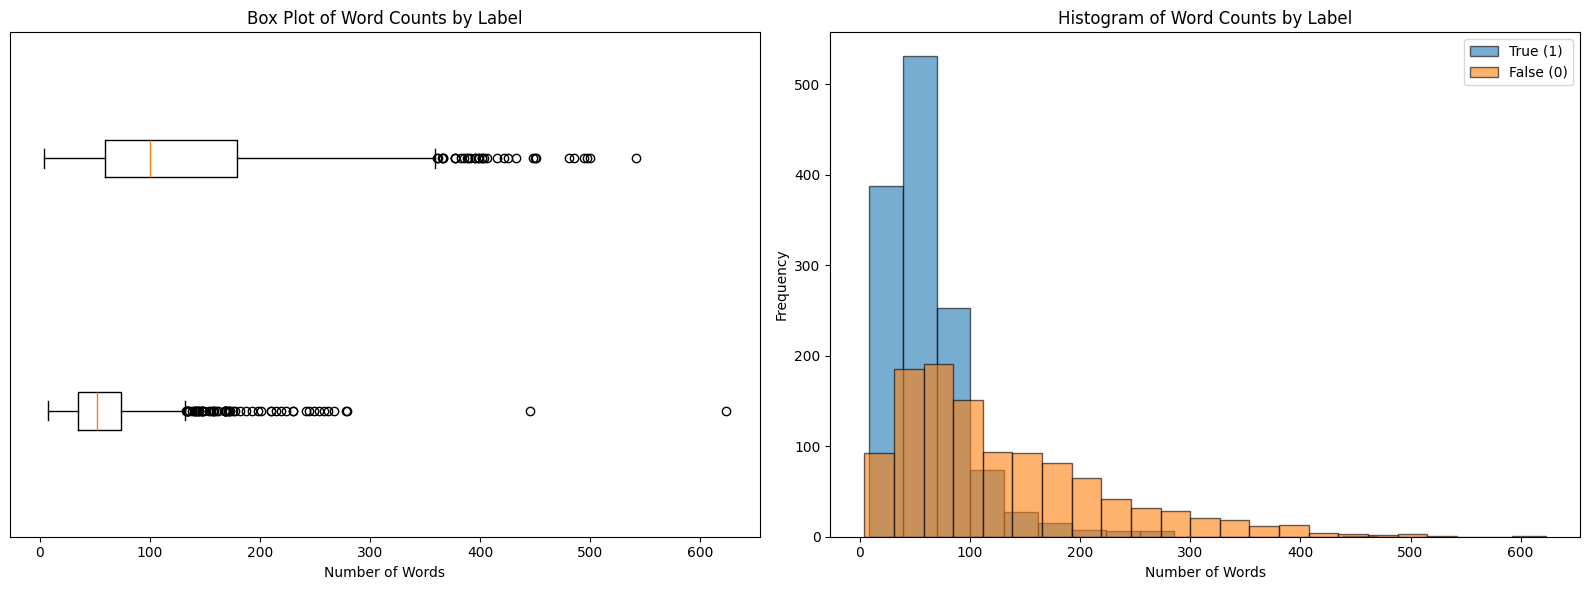

In [71]:
# Separate the two groups
true_counts  = train.loc[train["LABEL"] == 1, "W_COUNT"]
false_counts = train.loc[train["LABEL"] == 0, "W_COUNT"]

# (Optional) Print group-wise stats
print("True cases: ",
      f"max={true_counts.max()}, ",
      f"min={true_counts.min()}, ",
      f"avg={true_counts.mean():.2f}")
print("False cases:",
      f"max={false_counts.max()}, ",
      f"min={false_counts.min()}, ",
      f"avg={false_counts.mean():.2f}\n")

# Create 1×2 figure
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# ─── Box Plot by label ─────────────────────────────────────────────────────────
ax[0].boxplot(
    [true_counts, false_counts],
    labels=["True (1)", "False (0)"],
    vert=False
)
ax[0].set_title("Box Plot of Word Counts by Label")
ax[0].set_xlabel("Number of Words")
ax[0].set_yticks([])

# ─── Overlaid Histogram by label ───────────────────────────────────────────────
bins = 20
ax[1].hist(
    true_counts,
    bins=bins,
    edgecolor="black",
    alpha=0.6,
    label="True (1)"
)
ax[1].hist(
    false_counts,
    bins=bins,
    edgecolor="black",
    alpha=0.6,
    label="False (0)"
)
ax[1].set_title("Histogram of Word Counts by Label")
ax[1].set_xlabel("Number of Words")
ax[1].set_ylabel("Frequency")
ax[1].legend()

plt.tight_layout()
plt.show()


### The sampled false cases were also manually evaluated to identify misclassifications.

## 5. Bio_ClinicalBERT Classifier
### The following is a sample training run before deployment on a GPU.

In [ ]:
from Bio_ClinicalBERT import BioClinicalBERTClassifier

In [ ]:
classifier = BioClinicalBERTClassifier()
# classifier.check_layer_status()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
train = pd.read_csv("s_train.csv")

In [77]:
print(f"Distribution: {train['LABEL'].value_counts()}")

Distribution: LABEL
1.0    1309
0.0    1132
Name: count, dtype: int64


#### Sample dataset for code testing

In [ ]:
sample = train.sample(200, random_state=11)
print("CLASS COUNT:\n",sample["LABEL"].value_counts())

CLASS COUNT:
 1    100
0    100
Name: LABEL, dtype: int64


#### Training using 80-20 train-test split

Epoch 1/3 | Train Loss: 0.7115 | Test Loss: 0.6871
Epoch 2/3 | Train Loss: 0.7118 | Test Loss: 0.6867
Epoch 3/3 | Train Loss: 0.7100 | Test Loss: 0.6854


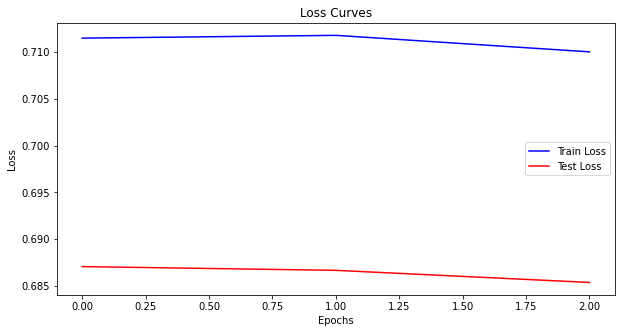

Total train time: 152.35 sec, Total test evaluation time: 24.78 sec


In [ ]:
result = classifier._run_train_epoch(
        data = sample,
        num_epochs=3,
        batch_size=16,
        test_split=0.2,  # 20% testing
        loss_threshold=None,
        shuffle_train=True,
        shuffle_test=False,
        cross_validation=False,
        cv_folds=5,
        verbose=True,
        print_every=1)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.43      0.60      0.50        20
     Class 1       0.33      0.20      0.25        20

    accuracy                           0.40        40
   macro avg       0.38      0.40      0.38        40
weighted avg       0.38      0.40      0.38        40



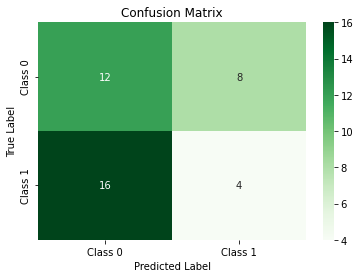

In [ ]:
classifier.print_classification_report(cmap = "Greens",
        true_labels=result['all_true_labels'],
        predictions=result['all_predictions']
    )

#### Training using cross-validation


=== Starting fold 1/5 ===
Fold 1/5, Epoch 1/2 | Train Loss: 0.7040 | Test Loss: 0.6910
Fold 1/5, Epoch 2/2 | Train Loss: 0.7170 | Test Loss: 0.6897

=== Starting fold 2/5 ===
Fold 2/5, Epoch 1/2 | Train Loss: 0.6962 | Test Loss: 0.6879
Fold 2/5, Epoch 2/2 | Train Loss: 0.6942 | Test Loss: 0.6877

=== Starting fold 3/5 ===
Fold 3/5, Epoch 1/2 | Train Loss: 0.6991 | Test Loss: 0.7024
Fold 3/5, Epoch 2/2 | Train Loss: 0.6914 | Test Loss: 0.7017

=== Starting fold 4/5 ===
Fold 4/5, Epoch 1/2 | Train Loss: 0.6955 | Test Loss: 0.6903
Fold 4/5, Epoch 2/2 | Train Loss: 0.7035 | Test Loss: 0.6897

=== Starting fold 5/5 ===
Fold 5/5, Epoch 1/2 | Train Loss: 0.6909 | Test Loss: 0.6995
Fold 5/5, Epoch 2/2 | Train Loss: 0.6977 | Test Loss: 0.6987


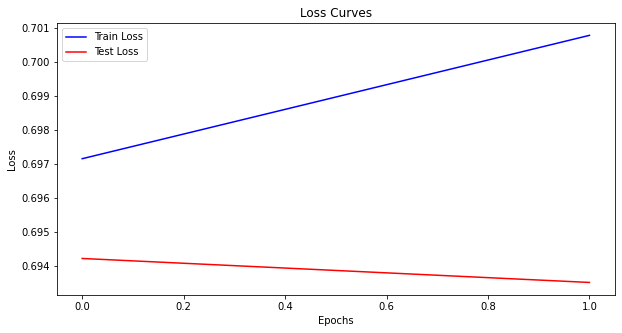

Total train time (all folds): 474.77 sec
Total test time (all folds): 70.18 sec


In [ ]:
rescv = classifier._run_train_epoch(
        data = sample,
        num_epochs=2,
        batch_size=16,
        test_split=0.2, # 20% testing
        loss_threshold=None,
        shuffle_train=True,
        shuffle_test=False,
        cross_validation=True,
        cv_folds=5,
        verbose=True,
        print_every=1)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.55      0.58      0.56        19
     Class 1       0.60      0.57      0.59        21

    accuracy                           0.57        40
   macro avg       0.57      0.58      0.57        40
weighted avg       0.58      0.57      0.58        40



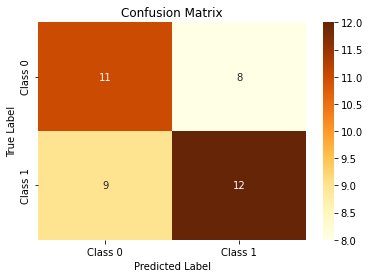

In [ ]:
classifier.print_classification_report(cmap = "YlOrBr",
    true_labels=rescv['all_true_labels'],
    predictions=rescv['all_predictions']
)

#### Optimizing the final layer of Bio_ClinicalBERT and the classification head parameters.

In [ ]:
classifier.unfreeze_last_layers(n=1)
classifier.check_layer_status()

bert.embeddings.word_embeddings.weight: requires_grad = False
bert.embeddings.position_embeddings.weight: requires_grad = False
bert.embeddings.token_type_embeddings.weight: requires_grad = False
bert.embeddings.LayerNorm.weight: requires_grad = False
bert.embeddings.LayerNorm.bias: requires_grad = False
bert.encoder.layer.0.attention.self.query.weight: requires_grad = False
bert.encoder.layer.0.attention.self.query.bias: requires_grad = False
bert.encoder.layer.0.attention.self.key.weight: requires_grad = False
bert.encoder.layer.0.attention.self.key.bias: requires_grad = False
bert.encoder.layer.0.attention.self.value.weight: requires_grad = False
bert.encoder.layer.0.attention.self.value.bias: requires_grad = False
bert.encoder.layer.0.attention.output.dense.weight: requires_grad = False
bert.encoder.layer.0.attention.output.dense.bias: requires_grad = False
bert.encoder.layer.0.attention.output.LayerNorm.weight: requires_grad = False
bert.encoder.layer.0.attention.output.LayerNorm.

Epoch 1/3 | Train Loss: 0.7094 | Test Loss: 0.7028
Epoch 2/3 | Train Loss: 0.7046 | Test Loss: 0.7015
Epoch 3/3 | Train Loss: 0.7091 | Test Loss: 0.7004


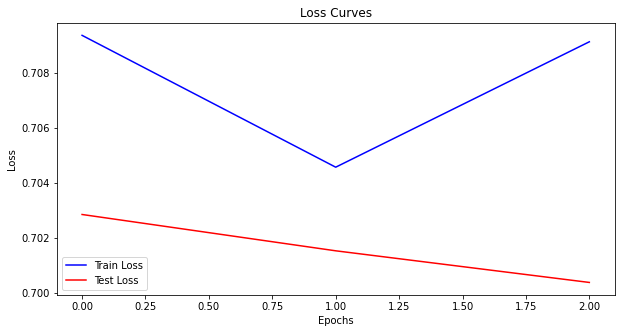

Total train time: 133.34 sec, Total test evaluation time: 21.60 sec


In [ ]:
res_llch = classifier._run_train_epoch(
        data = sample,
        num_epochs=3,
        batch_size=16,
        test_split=0.2, # 80% testing
        loss_threshold=None,
        shuffle_train=True,
        shuffle_test=False,
        cross_validation=False,
        cv_folds=5,
        verbose=True,
        print_every=1)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.50      0.25      0.33        20
     Class 1       0.50      0.75      0.60        20

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.47        40
weighted avg       0.50      0.50      0.47        40



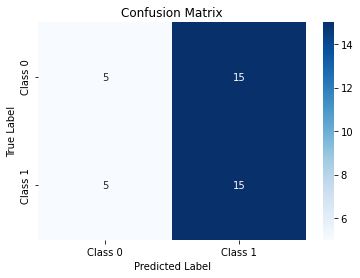

In [ ]:
classifier.print_classification_report(
    true_labels=res_llch['all_true_labels'],
    predictions=res_llch['all_predictions']
)

## 6. Multiclass Classifier for Subgroups (Beyond the Scope of This Research, Yet Potentially Beneficial)

In [ ]:
sub = train[train["SUBGROUP"].notna()].copy()
print("SUBGROUP Distribution:\n",sub["SUBGROUP"].value_counts())

SUBGROUP Distribution:
 7.0     1846
2.0      478
9.0      123
3.0       87
11.0      54
4.0       52
13.0      23
5.0       17
6.0       12
8.0        9
Name: SUBGROUP, dtype: int64


In [ ]:
sub.loc[:, "SUBGROUP"] = sub["SUBGROUP"].replace({4: 6})
sub.loc[:, "SUBGROUP"] = sub["SUBGROUP"].replace({3: 5})
sub = sub[~sub["SUBGROUP"].isin([9, 13, 8])]

In [ ]:
sub["SUBGROUP"] = sub["SUBGROUP"].astype(int)
# print("SUBGROUP Distribution:\n",sub["SUBGROUP"].value_counts())

In [ ]:
label_mapping = {2: 0, 5: 1, 6: 2, 7: 3, 11: 4}

# Remap the LABEL column
sub["LABEL"] = sub["SUBGROUP"].map(label_mapping)

print(sub["LABEL"].value_counts())

3    1846
0     478
1     104
2      64
4      54
Name: LABEL, dtype: int64


In [ ]:
# sub.to_csv("subgroups.csv", index=False)

In [ ]:
# Sample 50 entries from each 'SUBGROUP'
sampled_data = sub.groupby('SUBGROUP').apply(lambda x: x.sample(n=50, replace=True if len(x) < 50 else False)).reset_index(drop=True)

# Display the sampled data counts to verify
# print(sampled_data['SUBGROUP'].value_counts())

In [ ]:
sampled_data.rename(columns = {"LABEL":"MANUAL_ANOT", "SUBGROUP":"LABEL"}, inplace = True)

In [ ]:
# Define the mapping dictionary
label_mapping = {2: 0, 5: 1, 6: 2, 7: 3, 11: 4}

# Remap the LABEL column
sampled_data["LABEL"] = sampled_data["LABEL"].map(label_mapping)

# Verify the new distribution
print(sampled_data["LABEL"].value_counts())

0    50
1    50
2    50
3    50
4    50
Name: LABEL, dtype: int64


In [ ]:
for label, group in sampled_data.groupby("LABEL"):
    print(f"Label: {label}")
    print(group.head(2))
    print("-" * 80)

Label: 0
    ROW_ID                                     TEXT  W_COUNT  REGEX_LABEL  \
0   635921                           BIKE ACCIDENT.        2            1   
1  1000303  47 year old woman with bicycle vs. MVA.        8            1   

        KEYWORD  MANUAL_ANOT  LABEL  
0          bike            1      0  
1  bicycle, mva            1      0  
--------------------------------------------------------------------------------
Label: 1
    ROW_ID                                               TEXT  W_COUNT  \
50  838259  ATV ACCIDENT. 43 year old man w/ mult rib fx/p...       11   
51   35436  s/p Motorbike crash. 71 yo male s/p low speed ...       36   

    REGEX_LABEL              KEYWORD  MANUAL_ANOT  LABEL  
50            1                  atv            1      1  
51            1  dirtbike, motorbike            1      1  
--------------------------------------------------------------------------------
Label: 2
     ROW_ID                                               TEXT  W

In [ ]:
# Initialize the classifier for multi-class classification (5 classes)
mclassifier = BioClinicalBERTClassifier(num_labels=5, verbose=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | Train Loss: 1.6241 | Test Loss: 1.6164
Epoch 2/5 | Train Loss: 1.6314 | Test Loss: 1.6146
Epoch 3/5 | Train Loss: 1.6143 | Test Loss: 1.6120
Epoch 4/5 | Train Loss: 1.6145 | Test Loss: 1.6111
Epoch 5/5 | Train Loss: 1.6109 | Test Loss: 1.6105


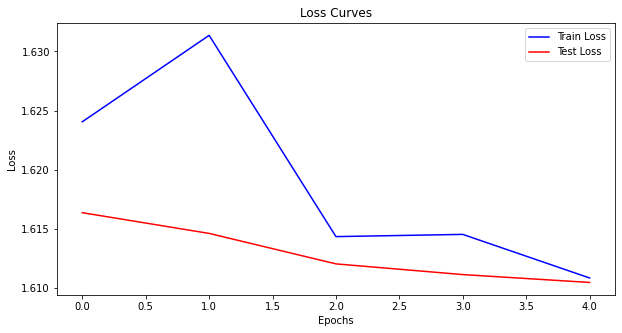

Total train time: 218.99 sec, Total test evaluation time: 9.76 sec


In [ ]:
result = mclassifier._run_train_epoch(
    data=sampled_data,
    num_epochs=5,         # set number of epochs as needed
    batch_size=16,        # adjust batch size
    test_split=0.2,       # 20% test split for single split training
    cross_validation=False,  # change to True for K-Fold CV
    verbose=True,
    print_every=1
)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.11      0.08      0.09        13
     Class 1       0.23      0.86      0.36         7
     Class 2       0.38      0.50      0.43        10
     Class 3       1.00      0.18      0.31        11
     Class 4       0.00      0.00      0.00         9

    accuracy                           0.28        50
   macro avg       0.35      0.32      0.24        50
weighted avg       0.36      0.28      0.23        50



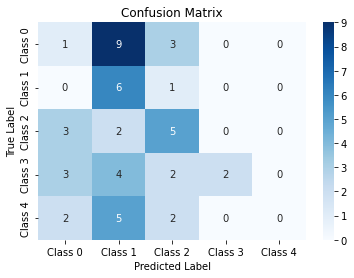

In [ ]:
mclassifier.print_classification_report(
    true_labels=result['all_true_labels'],
    predictions=result['all_predictions']
)

### The developed algorithms are trained on a GPU for loss optimization. The trained models are then tested on unseen data from the CEDRIC database.